# An Investigation of Political Partisanship Across Time using Data Science

By Vlad Dobrin and James Biggins

## Introduction and Motivation 









Politics has been at the forefront of many people’s minds in recent years, especially during this year’s pandemic. Due to political news and activism being spread or discussed in virtually every social media platform, more and more people are forming opinions about recent events. Opposing views have always brought conflict, but in the digitalization age of today, this has become more pronounced.

This year’s presidential election created international interest and discussion, leading to a record voter turnout. In contrast, congressional elections were discussed little. In fact, although virtually every American citizen knows who the current president of the United States is, many do not know their representatives in the two chambers of the Legislative Branch: the Senate and the House of Representatives. These representatives are responsible for the creation of the laws of the United States of America. If congress cannot come to an agreement, the government will grind to a halt, regardless of the divisiveness of the American people.

What happens when congress can’t agree? The consequences range depending on the importance of the bill, but disagreements in recent years have led to the [shutdown](http://www.crfb.org/papers/qa-everything-you-should-know-about-government-shutdowns) of the federal government and the absence of stimulus packages to the American people during this pandemic.

Why can’t agreements be reached? The modern American political system is, for all intents and purposes, a [two-party system](https://www.history.com/topics/us-presidents/america-101-why-do-we-have-a-two-party-system-video) that the Democratic and Republican parties have dominated. In recent years, it seems that representatives increasingly vote according to the will of the parties; thus, if there is no clear majority in a chamber of Congress, it becomes hard to pass legislature.

This paper attempts to determine if political partisanship has increased by gathering congressional voting records after 1940 and seeing if an increasing number of congressmen have voted together along party lines. Individual features of each vote are also included such as the type of motion, the representativeness of the decision, and the title of the vote. This project follows the Data Science steps of 
1.	Data Collection
2.	Data Processing
3.	Exploratory Analysis & Data Visualization
4.	Analysis, Hypothesis Testing, & Machine Learning
5.	Insight & Policy Decision

By the end, we create a model that shows the change in political partisanship over recent years and can predict the political partisanship of future congressional votes.

## Table of Contents



1.   Part 1: Data Collection
>*   Identify a raw data source
>*   Scrape the data

2. Part 2: Data Processing
>* Part 2a: Data Pre-processing
>>* Convert the individual arrays of information into two pandas dataframes
>>* Clean the scraped data
>>* Batch Download
>* Part 2b: Data Post-processing
>>* Batch Uploads
>>* Delete attribute that gets added during csv conversion
>>* Batch Stitching
>>* Final Cleaning
>>* Final Cleaning
>>* Final Post-Processing

**Checkpoint: Use our data to avoid the scraping steps above**

3. Part 3: Exploratory Analysis & Data Visualization
>* Senate Representation and PercentYea Analysis
>* Partisanship in Congress
>>* Partisanship in the Senate
>>* Partisanship in the House
4. Part 4: Analysis, Hypothesis Testing and Machine Learning
>* The Necessity of Averaging
>* Senate: Multilinear Linear Regression
>* House: Multilinear Linear Regression
>* Senate Ridge Regression
>* House Ridge Regression
>* Senate Nearest Neighbor
>* House Nearest Neighbor
5. Part 5: Insight, Policy Decision, and Importance
>* Summary
>* Financial Importance
>* Social Importance
>* The future of this project


# Part 1: Data Collection: Identify a raw data source

## Identify a raw data source

Data science requires data. In an ideal world, you get the data directly from the source. In this case, the closest thing to the source is government websites such as congress.gov, senate.gov, or house.gov. At a glance, this data would appear easy to scrape from (example: https://clerk.house.gov/Votes/2020235). However, this website does not appear to have easily accessible votes from the mid-1940’s. Instead, we turn to a website called [GovTrack.us](https://www.govtrack.us/), which is a reputable source that appears to have done data collection from websites in the government domain, as well as other public data sources such as https://voteview.com/. In this website, the voting records of from the 1st congress in 1789 are viewable in a format that can be automatically scraped.

Clearly, the US was very different in the 18th and 19th centuries. For one, there were a lot more political parties, including the Federalist party which is no longer influential today. Therefore, we narrowed the scope of our project to start at the beginning of 1941. The year was chosen due to party realignment reasons detailed here (https://history.house.gov/Exhibitions-and-Publications/BAIC/Historical-Essays/Keeping-the-Faith/Party-Realignment--New-Deal/) and also because this is a breakpoint in how these webpages were labeled in the GovTrack.us website, and we wanted to make scraping as streamlined as possible.

## Scrape the Data

### Import dependencies and libraries for project



In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from urllib.request import urlopen, Request
import matplotlib.pyplot as plt
from urllib.error import HTTPError
from google.colab import files
from time import sleep
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
import math
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Set up preliminary datastructures

Although the url naming convention for votes was fairly consistent, there was a few years that did not follow the same pattern. They are specified in the dictionary called houseFirstBill

In [ ]:
# required for establishing https connection
hdr = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',}

#dictionary to speed up scraping
houseFirstBill = {
        1972: 321,
        1974: 542,
        1976: 613,
        1978:707,
        1980:673,
        1982:355,
        1984:499,
        1986:440,
        1988:489,
        }

### Scrape the data

The scrape method goes to each vote webpage starting in either the house or the senate. Parameters:


*   chamber - specify which chamber is scraped
*   congressNumStart - the first congress to scrape. Ensure it lines up with year
* congressNumEnd - specifies the last congresss to scrape
* year - the start year to scape. Ensure it lines up with congressNumStart
* interval- how many votes in a year are scraped in a row. An interval of 1 would mean that every vote is scraped, an interval two means that every other vote is scraped, and so on

**Explanation of the scrape**
Each vote takes a couple seconds to scrape over my internet connection, so from start to finish the scraping process would have taken multiple days to complete if executed all at once. 

How to scrape all the house data: 
* scrape('House',11,116, 1941, 1)

How to scrape all the senate data:
* scrape('Senate',11,116, 1941, 1)

During the scraping process, because we used Google Colab and due to the large number of votes that are available to gather, code execution would frequently stop and all the data scraped would be lost. 

As this happened multiple times over the 2 week scraping process, I realized that the execuion would stop more frequently in the later end of the scrape. Therefore, I did a preliminary scrape for both chambers to get as much of the data as I could. Then, using the parameters of the scrape function, I got the data decade by decade. In the post processing step later on in this project, the data from the numerous individual scrapes are combined.

How to scrape the senate data from the 1980's:
* scrape('House',96,101, 1979, 1)

If you are looking to test this scrape yourself, you might find that getting every vote even from a decade takes some time. However, if you choose a smaller time frame AND a bigger interval, you can get a sample of votes quickly.

How to scrape every 20th vote from the 1980's
* scrape('House',96,101, 1979, 20)

Important notes: 
1. When specifying the start year, ensure it aligns with the FIRST year for that congress. For example, the 101st congress lasts from 1979 to 1980. Please choose 1979 as the start year, even if you only want the 80's.
2. How do you know which congresses go which years, and so forth? Go to https://www.govtrack.us/congress/votes and look at the dropdown filter on the left side of the page.
3. When scraping a subset of votes, hereby called a **"batch"**, run the *entirity* of the following cell so that the previous batch's results are cleared from the arrays.
4. Don't be alarmed if you see errors while scraping, 404's are expected as part of the scraping process and 502s are handled with a constant retry policy that is simplistic, un-optimized, yet effective. For example: running the above scrape yields:

>>```
starting  House :  96 year  1979 vote# 1
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/96-1979/h681
starting  House :  96 year  1980 vote# 673
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/96-1980/h1293
```

>>This is fine, its simply telling you that it tried to scrape votes from 1 to 681, before realizing that there are no more votes for that year. Then it tells you which vote it will start off on in the next year.

In [ ]:
voteID = 0 #the id for votes in the congress table and repeated as an index in the votes table
CID = 0 # a unique identifier for year, congress combination

# lists to store the scraped information
CIDs = []
CongressNames = []
Dates = []
CongressYears = []
SeqVoteIDs = []
Titles = []
Motions =[]
Representations = []
PercentYea = []
URLS = []
Chambers = []

VoteIDs = []
TypesofVotes = []
PercentsofVote = []
NumbersofVotes = []
Pubs = []
Dems = []

#the method that performs the actual scaping
def scrape(chamber, congressNumStart, congressNumEnd, year, interval):
  global CID
  global voteID
  
  year -=1 # need to subtract one in the begining so the addition in the loop works
  congressNumEnd +=1

  for congressNum in range(congressNumStart, congressNumEnd): #end at 116
    
    for i in range(2):
      
      foundFirst = False
      year +=1

      #the vote number for that congress and year
      if chamber == 'House':
        voteNum = houseFirstBill.get(year, 1)
      else:
          voteNum = 1

      print("starting ", chamber, ": ", congressNum, "year " , year, "vote#", voteNum)

      
      #get all webpages that you can from the senate
      while True:
        
        url = 'https://www.govtrack.us/congress/votes/' + str(congressNum) + '-' + str(year) + '/' + str(chamber[0]).lower() + str(voteNum)

        #make request
        req = Request(url, headers=hdr)
        #try to read response
        try:
          response = urlopen(req).read()

          #give to soup to organize
          soup = BeautifulSoup(response, 'lxml')

          # print("found ", url)
          foundFirst = True

          URLS.append(url)
          Titles.append(soup.h1.text)
          date = soup.find("div",{"style":"margin: 2px 0 16px 0; font-size: 12px; font-weight: normal; color: black; line-height: 125%; padding-bottom: 6px; border-bottom: 1px solid #CCA;"}).text
          Dates.append(date)
          Chambers.append(chamber)
          
          #get extra info
          motion = soup.find('p',{"style":"margin: 1em 0 0 0; font: 12px/20px serif;"})
          if motion is None:
            Motions.append("unknown")
          else:
            Motions.append(motion.text)

          representation = soup.find('p',{"style":"margin: 0; font: 12px/20px serif;"})
          if representation is None:
            Representations.append("unknown")
          else:
            Representations.append(re.findall('\d+', representation.text)[0])

          #get vote info into DF, its the second to last table
          table = soup.find_all('table')[len(soup.find_all('table'))-2]
          df1 = pd.read_html(str(table), flavor='html5lib')[0]

          #update listCongress columns
          CIDs.append(CID)
          CongressNames.append(congressNum)
          CongressYears.append(year)
          SeqVoteIDs.append(voteID)
          
          if df1['Unnamed: 0'].size > 0 and df1.loc[0, 'Unnamed: 0'] == 'Yea':
            PercentYea.append(str(df1.loc[0, 'All Votes'])[:-1])
          else:
            PercentYea.append('unknown')
          
          #update vote columns
          for index, row in df1.iterrows():
                    
            VoteIDs.append(voteID)
            TypesofVotes.append(df1.loc[index, 'Unnamed: 0'])     
            NumbersofVotes.append(df1.loc[index, 'All Votes.1'])
            Pubs.append(df1.loc[index, 'Republicans'])
            Dems.append(df1.loc[index, 'Democrats'])      

          voteID +=1
          voteNum += interval
          CID +=1

        except HTTPError as err:
          print(err, url)
          if err.code == 404:
            if foundFirst:
              break
            elif voteNum > 750:
              break
            else:
              voteNum += interval

          elif err.code == 502:
            sleep(2)



#!!!change the line below to scrape a batch of your choosing!!!
scrape('House',96,97, 1979, 30)

starting  House :  96 year  1979 vote# 1
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/96-1979/h691
starting  House :  96 year  1980 vote# 673
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/96-1980/h1303
starting  House :  97 year  1981 vote# 1
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/97-1981/h361
starting  House :  97 year  1982 vote# 355
HTTP Error 404: Not Found https://www.govtrack.us/congress/votes/97-1982/h835


# Part 2: Data Processing

## Part 2a: Data Pre-processing

At this point, you have successfully scraped a batch of votes from a single chamber into arrays. These arrays are then put in pandas dataframes before being cleaned. How should this information be organized? The solution we devised was a dual table/dataframe system. 

The first table would list each vote scraped: a single vote would have a single entry. Attributes:
*   CID - the unique indentifier for a year, congress combination
*   CName - the name of the congress, represented numerically, ex(101) 
* Date - the date of that the vote occured
* Chamber - the chamber of the vote
* VoteID - the unique identifier for a vote. 
* Motions - The motion specified for each vote.
* PercentYea - the percent of votes that supported the motion
* Representation - " The Yea votes represented 47% of the country’s population by apportioning each state’s population to its voting senators." - GovTrack.us
* URL - the URL that each vote can be viewed. Acts as a good manual "sanity check" to ensure that the entries have the correct data.
*  VoteTitle - the title of the vote

The second table goes into detail for each vote. Each entry lists a type of action for each vote and who voted for that action. Attributes:
* VID - the vote ID that identifies each vote. Each vote should have 1+ rows for the 1+ actions
* Type - the type of action that can be done on each vote. There will always be a Yea action for each vote. There will almost always be a Nay action, and occassionally actions for Present and Not Voting.
* Number - how many total people took that action
* Republicans - how many republicans took that action
* Democrats - how many democrats took that action
* Others - although we confined the range of years so that Democrats and Republicans would be the major parties in play, the website occassionally lists the votes of Independents, Progressives, or unknowns that add a couple votes to the total. We are combining these three groups because they are not gaurenteed to be present in every congress.

Note: the current code has each batch's CID and VoteID start at 0. We then "fix" these values in post processing so they are unique for the combined data. If you want to avoid that step, you can add an extra parameter to the scrape function that specifies the initial value that CID and VoteID should have.


### Convert the individual arrays of information into the two dataframes

Dataframes called
* congressTable
* voteTable



In [ ]:
congressTable = pd.DataFrame(columns=["CID", "CName", "Date", "Chamber", "VoteID", 'Motions', 'PercentYea','Representation', "URL"])
voteTable = pd.DataFrame(columns=["VID", "Type", "Number", "Republicans", "Democrats", "Others"])

congressTable['CID'] = CIDs
congressTable['CName'] = CongressNames
congressTable['Date'] = Dates
congressTable['Chamber'] = Chambers
congressTable['VoteID'] = SeqVoteIDs
congressTable['VoteTitle'] = Titles
congressTable['Motions'] = Motions
congressTable['PercentYea'] = PercentYea
congressTable['Representation'] = Representations
congressTable['URL'] = URLS

voteTable['VID'] = VoteIDs
voteTable['Type'] = TypesofVotes
voteTable['Number'] = NumbersofVotes
voteTable['Democrats'] = Dems
voteTable['Republicans'] = Pubs



### Clean the scraped data

The initial scrapes take a while, so virtually no cleaning takes place during the scraping process so it can complete as quickly as possible. The majority of the cleaning of the data takes place here, mostly doing things like trimming html tags

In [ ]:
#calc others (progressives, independents, unknowns)
voteTable['Others'] = voteTable['Number'] - voteTable['Republicans'] - voteTable['Democrats']

# perform mapping from month abbreviation to number
m = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr':4,
         'May':5,
         'Jun':6,
         'Jul':7,
         'Aug':8,
         'Sep':9,
         'Oct':10,
         'Nov':11,
         'Dec':12
        }

#method that converts raw month to a datetime value
def convertToDT(string):
  match = re.findall('\d+', string)
  day = match[0]
  year = match[1]
  month = re.findall('[A-Z][a-z]+', string)[0]

  return pd.to_datetime( str(m[month]) + "/" + str(day) + "/"  + str(year) )

#cleaning down for every row
for index, row in congressTable.iterrows():
  #convert dates to date time
  congressTable.loc[index, 'Date'] = convertToDT(str(congressTable.loc[index, 'Date']))

  #clean motions into motion
  string1= re.sub('\n|\s', '', congressTable.loc[index, 'Motions'])
  matches = string1.split('.')
  if matches[1] == 'unknownRequired':
    matches[1] = 'unknown'
  congressTable.loc[index, 'Motion'] = matches[0]
  congressTable.loc[index, 'RequirementsToPass'] = matches[1]

  #clean representations
  congressTable.loc[index, 'Representation'] = re.sub('\n', '', congressTable.loc[index, 'Representation'])

  #clean title
  congressTable.loc[index, 'VoteTitle'] = re.sub('\n', '', congressTable.loc[index, 'VoteTitle'])

  #clean yea
  if(congressTable.loc[index,'PercentYea'] == 'na'):
    congressTable.loc[index,'PercentYea'] = 0

# drop motions column
congressTable.drop(columns=['Motions'], inplace=True)

### Batch Download

At this stage, you have a batch of cleaned vote data in two dataframes. Although there is no foreign key relationship, the tables are linked by the VoteID. For the purposes of this project, download the two csvs, knowing that you HAVE to preserve the voteID link, the voteIDs can change later, but a entry in the congressTable needs to map to the same set of entries in the voteTable.

In [ ]:

voteTable.to_csv('voteTable.csv')
congressTable.to_csv('congressTable.csv')

files.download('voteTable.csv')
files.download('congressTable.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 2b: Data Post-processing

If you have a number of batch csv files for the senate and house, we need to re-upload them and join them. The exact code below will depend on the how many batches you have, this is what we did for our batches.

### Batch Uploads

This code is specific for Google Collab execution

In [ ]:
#Necessary to bring in the csv file from the drive for someone that does not have it locally.
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

#senate
linkCT03A = "https://drive.google.com/file/d/1_8QrsbNSGfQpekb0XH9N3uwSK2ON0vXf/view?usp=sharing";
linkCT03B = "https://drive.google.com/file/d/1PW_ZDISK_pTYXvGL74_dE-0__BLqDMWQ/view?usp=sharing";
linkVT03A = "https://drive.google.com/file/d/1-LcPvUfYNPsWByHzchiAlBOftIlp__eV/view?usp=sharing";
linkVT03B = "https://drive.google.com/file/d/1hyHekveQCgVC9_vqyHP5ku9Nolrqvd_T/view?usp=sharing";
linkS1990 = "https://drive.google.com/file/d/188IA0q6s6mdpWKcQHRrxlw1VjSBXQXNb/view?usp=sharing";
linkS2000 = "https://drive.google.com/file/d/1WJWfcKg_R27j2jtxM1iVSWcU9Rhtp7kE/view?usp=sharing";
linkS2010 = "https://drive.google.com/file/d/13xTwibyBr3xCyrJNctFJC_reCgBww7HC/view?usp=sharing";
linkSV1990 = "https://drive.google.com/file/d/14otYJU6hkob_vrGR_lzozEGGPBGo45Xe/view?usp=sharing";
linkSV2000 = "https://drive.google.com/file/d/1BXTbhVCKE5UJdoMqMbkz5uWmY23bD8r8/view?usp=sharing";
linkSV2010 = "https://drive.google.com/file/d/1BtaXljJ_6Hr1WK2H1pET71rdE2vcPh2v/view?usp=sharing";

#house
linkHT03A = "https://drive.google.com/file/d/1VhJl_MAZ-qY3Q-UfKHgHi0sVAWdrdfYI/view?usp=sharing";
linkHVT03A = "https://drive.google.com/file/d/1HSbymM3QzshxHxO4W2uxfpvJleP1bQgm/view?usp=sharing";
linkHT1970 = "https://drive.google.com/file/d/1T3vJsVjSPBBlr8NYk4aL-AQfXHSJp8Dk/view?usp=sharing"
linkHT1980 = "https://drive.google.com/file/d/10a5YAj0cBS_eU6k-1eBKVjq-GjBymBtg/view?usp=sharing"
linkHT1990 = "https://drive.google.com/file/d/17KKG-kmfVbDh5aU4eaqymTzaH5Vt7dhj/view?usp=sharing"
linkHT2000 = "https://drive.google.com/file/d/1oDYT6JObLeP2ckuVTwKr6qVYW0_DfDDv/view?usp=sharing"
linkHT2010 = "https://drive.google.com/file/d/1CGOQLuNf_a6NupPdxI51SYyecoB7w68B/view?usp=sharing"
linkHVT1970 = "https://drive.google.com/file/d/1zhNFLkQO_wtgoPUFGxXGNpCa-6ObdpAC/view?usp=sharing"
linkHVT1980 = "https://drive.google.com/file/d/11qI7YlATHsFi9zNEAgEMaUVdYfRns_cr/view?usp=sharing"
linkHVT1990 = "https://drive.google.com/file/d/1cU5QTCOp7qamXYE29p1O4IFBCsoAB6Cs/view?usp=sharing"
linkHVT2000 = "https://drive.google.com/file/d/1diV1rEC3xLo5jbnSU6soK-rnZcwuVYUr/view?usp=sharing"
linkHVT2010 = "https://drive.google.com/file/d/1DbT7Ksf6_cWC4VtCwqGtbfen1NnGct0E/view?usp=sharing"

idC03A = linkCT03A.split("/")[-2] 
idC03B = linkCT03B.split("/")[-2] 
idS1990 = linkS1990.split("/")[-2] 
idS2000 = linkS2000.split("/")[-2] 
idS2010 = linkS2010.split("/")[-2] 

idV03A = linkVT03A.split("/")[-2] 
idV03B = linkVT03B.split("/")[-2] 
idSV1990 = linkSV1990.split("/")[-2] 
idSV2000 = linkSV2000.split("/")[-2] 
idSV2010 = linkSV2010.split("/")[-2] 


idH03A = linkHT03A.split("/")[-2] 
idH1970 = linkHT1970.split("/")[-2] 
idH1980 = linkHT1980.split("/")[-2] 
idH1990 = linkHT1990.split("/")[-2] 
idH2000 = linkHT2000.split("/")[-2] 
idH2010 = linkHT2010.split("/")[-2] 

idHV03A = linkHVT03A.split("/")[-2]
idHV1970 = linkHVT1970.split("/")[-2] 
idHV1980 = linkHVT1980.split("/")[-2] 
idHV1990 = linkHVT1990.split("/")[-2] 
idHV2000 = linkHVT2000.split("/")[-2] 
idHV2010 = linkHVT2010.split("/")[-2] 
 
#senate data
downloadedC03A = drive.CreateFile({'id':idC03A})  
downloadedC03A.GetContentFile('senateTable03a.csv')
downloadedC03B = drive.CreateFile({'id':idC03B})  
downloadedC03B.GetContentFile('senateTable03b.csv')
downloadedV03A = drive.CreateFile({'id':idV03A})  
downloadedV03A.GetContentFile('senateVoteTable03a.csv')
downloadedV03B = drive.CreateFile({'id':idV03B})  
downloadedV03B.GetContentFile('senateVoteTable03b.csv')
downloadedS1990 = drive.CreateFile({'id':idS1990})  
downloadedS1990.GetContentFile('senDec1990.csv')
downloadedS2000 = drive.CreateFile({'id':idS2000})  
downloadedS2000.GetContentFile('senDec2000.csv')
downloadedS2010 = drive.CreateFile({'id':idS2010})  
downloadedS2010.GetContentFile('senDec2010.csv')
downloadedSV1990 = drive.CreateFile({'id':idSV1990})  
downloadedSV1990.GetContentFile('senVDec1990.csv')
downloadedSV2000 = drive.CreateFile({'id':idSV2000})  
downloadedSV2000.GetContentFile('senVDec2000.csv')
downloadedSV2010 = drive.CreateFile({'id':idSV2010})  
downloadedSV2010.GetContentFile('senVDec2010.csv')

#house data
downloadedH03A = drive.CreateFile({'id':idH03A})  
downloadedH03A.GetContentFile('houseTable03a.csv')
downloadedHV03A = drive.CreateFile({'id':idHV03A})  
downloadedHV03A.GetContentFile('houseVoteTable03a.csv')
downloadedH1970 = drive.CreateFile({'id':idH1970})  
downloadedH1970.GetContentFile('houDec1970.csv')
downloadedHV1970 = drive.CreateFile({'id':idHV1970})  
downloadedHV1970.GetContentFile('houVDec1970.csv')
downloadedH1980 = drive.CreateFile({'id':idH1980})  
downloadedH1980.GetContentFile('houDec1980.csv')
downloadedHV1980 = drive.CreateFile({'id':idHV1980})  
downloadedHV1980.GetContentFile('houVDec1980.csv')
downloadedH1990 = drive.CreateFile({'id':idH1990})  
downloadedH1990.GetContentFile('houDec1990.csv')
downloadedHV1990 = drive.CreateFile({'id':idHV1990})  
downloadedHV1990.GetContentFile('houVDec1990.csv')
downloadedH2000 = drive.CreateFile({'id':idH2000})  
downloadedH2000.GetContentFile('houDec2000.csv')
downloadedHV2000 = drive.CreateFile({'id':idHV2000})  
downloadedHV2000.GetContentFile('houVDec2000.csv')
downloadedH2010 = drive.CreateFile({'id':idH2010})  
downloadedH2010.GetContentFile('houDec2010.csv')
downloadedHV2010 = drive.CreateFile({'id':idHV2010})  
downloadedHV2010.GetContentFile('houVDec2010.csv')

#senate
inputedCongressTablea = pd.read_csv('senateTable03a.csv') 
inputedCongressTableb = pd.read_csv('senateTable03b.csv') 
ist1990 = pd.read_csv('senDec1990.csv') 
ist2000 = pd.read_csv('senDec2000.csv') 
ist2010 = pd.read_csv('senDec2010.csv') 
inputedVoteTablea = pd.read_csv('senateVoteTable03a.csv') 
inputedVoteTableb = pd.read_csv('senateVoteTable03b.csv')
isvt1990 = pd.read_csv('senVDec1990.csv') 
isvt2000 = pd.read_csv('senVDec2000.csv') 
isvt2010 = pd.read_csv('senVDec2010.csv') 

#house
inputedHouseTablea = pd.read_csv('houseTable03a.csv') 
inputedhouseVoteTablea = pd.read_csv('houseVoteTable03a.csv') 
iht1970 = pd.read_csv('houDec1970.csv') 
iht1980 = pd.read_csv('houDec1980.csv') 
iht1990 = pd.read_csv('houDec1990.csv') 
iht2000 = pd.read_csv('houDec2000.csv') 
iht2010 = pd.read_csv('houDec2010.csv') 
ihvt1970 = pd.read_csv('houVDec1970.csv') 
ihvt1980 = pd.read_csv('houVDec1980.csv') 
ihvt1990 = pd.read_csv('houVDec1990.csv') 
ihvt2000 = pd.read_csv('houVDec2000.csv') 
ihvt2010 = pd.read_csv('houVDec2010.csv') 

### Delete attribute that gets added during csv conversion

In [ ]:
#additional columns that need to be deleted
del ist1990['Unnamed: 0']
del ist2000['Unnamed: 0']
del ist2010['Unnamed: 0']
del isvt1990['Unnamed: 0']
del isvt2000['Unnamed: 0']
del isvt2010['Unnamed: 0']
del inputedCongressTablea['Unnamed: 0']
del inputedCongressTableb['Unnamed: 0']
del inputedVoteTablea['Unnamed: 0']
del inputedVoteTableb['Unnamed: 0']


In [ ]:
#delete artifacts from Excel
del iht1970['Unnamed: 0']
del iht1980['Unnamed: 0']
del iht1990['Unnamed: 0']
del iht2000['Unnamed: 0']
del iht2010['Unnamed: 0']
del ihvt1970['Unnamed: 0']
del ihvt1980['Unnamed: 0']
del ihvt1990['Unnamed: 0']
del ihvt2000['Unnamed: 0']
del ihvt2010['Unnamed: 0']
del inputedHouseTablea['Unnamed: 0']
del inputedhouseVoteTablea['Unnamed: 0']


### Batch Stitching
The next set of steps is to take the different senate/house tables and senate/house vote tables and to stitch them all together into a singular senate/house table and singular senate/house vote table.

Again, the most important thing is to preseve the link between the voteIDs of the two tables, although we also ensure that there are no duplicate CIDs.

In [ ]:
#columns that needed to be deleted and duplicate data from senate table b needed to be dropped
inputedCongressTableb = inputedCongressTableb[:8763] #only keep stuff before 1990 because everything after will be added by decade

In [ ]:
#merging the congressTable together since were seperated due to size issues. This is putting a + b together
inputedCongressTableb['CID'] = inputedCongressTableb['CID'] + len(inputedCongressTablea['CID']);
inputedCongressTableb['VoteID'] = inputedCongressTableb['VoteID'] + len(inputedCongressTablea['VoteID']);

frames = [inputedCongressTablea, inputedCongressTableb];
inputedCongressTable = pd.concat(frames, sort = False);
inputedCongressTable = inputedCongressTable.reset_index();
del inputedCongressTable['index'];

#changing all the types to int or float for later operations
inputedCongressTable.astype({'CID': 'int32'});
inputedCongressTable.astype({'CName' : 'int32'});
inputedCongressTable.astype({'VoteID': 'int32'});
inputedCongressTable['PercentYea'] = inputedCongressTable['PercentYea'].replace("unknown", np.NaN);
inputedCongressTable.astype({'PercentYea': 'float'});
inputedCongressTable['Representation'] = inputedCongressTable['Representation'].replace("unknown", np.NaN);
inputedCongressTable.astype({'Representation': 'float'});


In [ ]:
#This function takes in 2 dataframes that are used to add to the second argument
#needed to work over all the different decades that we have
def fix(smaller, addingTo):
  smaller['CID'] = smaller['CID'] + addingTo.iloc[len(addingTo)-1, 0] + 1
  smaller['VoteID'] = smaller['VoteID'] + addingTo.iloc[len(addingTo)-1, 4] + 1

  frames = [addingTo, smaller]
  addingTo = pd.concat(frames, sort = False)
  addingTo = addingTo.reset_index()
  del addingTo['index']

  return addingTo 

In [ ]:

inputedCongressTable = fix(ist1990, inputedCongressTable)
inputedCongressTable = fix(ist2000, inputedCongressTable)
inputedCongressTable = fix(ist2010, inputedCongressTable)


In [ ]:
inputedVoteTableb = inputedVoteTableb[:25517] # needed to find in the csv file b where 1991 first started and drop that to use the proper decades table
#this was cross referenced via VID in the corresponding senateTable data

In [ ]:
#merging votetables a + b of senate together
inputedVoteTableb['VID'] = inputedVoteTableb['VID'] + len(inputedCongressTablea['CID']) #ensuring proper VID on b starting from where a left off

#concatenating them together
frames = [inputedVoteTablea, inputedVoteTableb]
inputedVoteTable = pd.concat(frames, sort = False)
inputedVoteTable = inputedVoteTable.reset_index()
del inputedVoteTable['index']


In [ ]:
def fixVT(smaller, addingTo):
  #merging votetables a + b of senate together
  smaller['VID'] = smaller['VID'] + addingTo.iloc[len(addingTo['VID'])- 1, 0] + 1 #ensuring proper VID on b starting from where a left off

  #concatenating them together
  frames = [addingTo, smaller]
  addingTo = pd.concat(frames, sort = False)
  addingTo = addingTo.reset_index()
  del addingTo['index']
  return addingTo


In [ ]:
#call our functions to correctly stitch everything together
inputedVoteTable = fixVT(isvt1990, inputedVoteTable)
inputedVoteTable = fixVT(isvt2000, inputedVoteTable)
inputedVoteTable = fixVT(isvt2010, inputedVoteTable)


In [ ]:
#call our functions to correctly stitch everything together
inputedHouseTable = fix(iht1970, inputedHouseTablea);
inputedHouseTable = fix(iht1980, inputedHouseTable);
inputedHouseTable = fix(iht1990, inputedHouseTable);
inputedHouseTable = fix(iht2000, inputedHouseTable);
inputedHouseTable = fix(iht2010, inputedHouseTable);

In [ ]:
#call out functions to correctly stitch everything together
inputedHouseVoteTable = fixVT(ihvt1970, inputedhouseVoteTablea);
inputedHouseVoteTable = fixVT(ihvt1980, inputedHouseVoteTable);
inputedHouseVoteTable = fixVT(ihvt1990, inputedHouseVoteTable);
inputedHouseVoteTable = fixVT(ihvt2000, inputedHouseVoteTable);
inputedHouseVoteTable = fixVT(ihvt2010, inputedHouseVoteTable);

### Final Cleaning

Ensure dates are in date-time format so we can easily reference months/years later in later ML sections.

In [ ]:
#Change to date time
inputedHouseTable['Date'] = pd.to_datetime(inputedHouseTable['Date'], format='%Y-%m-%d')

In [ ]:
#Changing the date from string to date time
inputedCongressTable['Date'] = pd.to_datetime(inputedCongressTable['Date'], format='%Y-%m-%d')


### Final Post-Processing

The more variables or attributes that are provided, the more options that you have when building machine learning models. We wanted to incorporate three more attributes to each vote that are not explicitly generated in the scrape that might aid in building a comprehensive model.

1. 4Code - This attribute represents the years that a president has been in office, per term. For example, Obama was elected in 2008, so 2008 has a 4code of 0. 2009, 2010, and 2011 have the codes 1,2, and 3 respectively. He was re-elected in 2012, so 2012 has a 4code of of 0. This pattern repeats. Because presidents have four year terms, this is essentially year % 4
2. 8Code -  This attribut represents the years that a president has been in office, over both terms. As with code4, 2008 has a 4code of 0. 2009, 2010, and 2011 still have the codes 1,2, and 3 respectively. However, 2012 has a code8 == 4 and 2013, 2014, 2015 have code8's of 5, 6, and 7 respectively.
3. Month - the month that the vote occured.

In [ ]:
#Note that you have to manually enter the 8Code converter dictionary based on election results.
CodeConverter = {
        1940: 0,
        1941: 1,
        1942: 2,
        1943: 3,
        1944: 4,
        1945: 5,
        1946: 6,
        1947: 7,
        1948: 0,
        1949: 1,
        1950: 2,
        1951: 3,
        1952: 0,
        1953: 1,
        1954: 2,
        1955: 3,
        1956: 4,
        1957: 5,
        1958: 6,
        1959: 7,
        1960: 0,
        1961: 1,
        1962: 2,
        1963: 3,
        1964: 4,
        1965: 5,
        1966: 6,
        1967: 7,
        1968: 0,
        1969: 1,
        1970: 2,
        1971: 3,
        1972: 4,
        1973: 5,
        1974: 6,
        1975: 7,
        1976: 0,
        1977: 1,
        1978: 2,
        1979: 3,
        1980: 0,
        1981: 1,
        1982: 2,
        1983: 3,
        1984: 4,
        1985: 5,
        1986: 6,
        1987: 7,
        1988: 0,
        1989: 1,
        1990: 2,
        1991: 3,
        1992: 0,
        1993: 1,
        1994: 2,
        1995: 3,
        1996: 4,
        1997: 5,
        1998: 6,
        1999: 7,
        2000: 0,
        2001: 1,
        2002: 2,
        2003: 3,
        2004: 4,
        2005: 5,
        2006: 6,
        2007: 7,
        2008: 0,
        2009: 1,
        2010: 2,
        2011: 3,
        2012: 4,
        2013: 5,
        2014: 6,
        2015: 7,
        2016: 0,
        2017: 1,
        2018: 2,
        2019: 3,
        2020: 0,
        }

In [ ]:
#adding the code converter digits to the respective spots in the dataframe to be used for ML later!
for index, row in inputedCongressTable.iterrows():
  inputedCongressTable.loc[index, '4Code'] = inputedCongressTable.loc[index, 'Date'].year %4
  inputedCongressTable.loc[index, '8Code'] = CodeConverter[inputedCongressTable.loc[index, 'Date'].year]
  inputedCongressTable.loc[index, 'Month'] = inputedCongressTable.loc[index, 'Date'].month


In [ ]:
for index, row in inputedHouseTable.iterrows():
  inputedHouseTable.loc[index, '4Code'] = inputedHouseTable.loc[index, 'Date'].year %4
  inputedHouseTable.loc[index, '8Code'] = CodeConverter[inputedHouseTable.loc[index, 'Date'].year]
  inputedHouseTable.loc[index, 'Month'] = inputedHouseTable.loc[index, 'Date'].month


### Download finished data

At this point, we reccommend the final tables, so you can have a saved copy of them, and you can follow the steps of everyone else who is coming in at that point.

In [ ]:
inputedCongressTable.to_csv('senateCongressTable.csv')
inputedHouseTable.to_csv('houseCongressTable.csv')
inputedVoteTable.to_csv('senateVoteTable.csv')
inputedHouseVoteTable.to_csv('houseVoteTable.csv')

files.download('senateCongressTable.csv')
files.download('houseCongressTable.csv')
files.download('senateVoteTable.csv')
files.download('houseVoteTable.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Checkpoint: Use our data to avoid scraping

At this point, we have finalized 4 tables that have all the raw data needed for the rest of the project. We reccommend that people interested in recreating this project to begin code execution at this point, before we begin further analysis.

### Read in CSVs

In [ ]:
inputedCongressTable = pd.read_csv('/content/senateCongressTable.csv')
inputedHouseTable = pd.read_csv('/content/houseCongressTable.csv')
inputedVoteTable = pd.read_csv('/content/senateVoteTable.csv')
inputedHouseVoteTable = pd.read_csv('/content/houseVoteTable.csv')

### Clean dataframes

Same methods as before

In [ ]:
del inputedCongressTable['Unnamed: 0']
del inputedHouseTable['Unnamed: 0']
del inputedVoteTable['Unnamed: 0']
del inputedHouseVoteTable['Unnamed: 0']

You are now ready to continue on to part 3

# Part 3: Exploratory Analysis & Data Visualization

### Senate Representation and PercentYea Analysis

The Senate tables have the attribute Representation that was scraped into the congressTable dataframe. This attribute indicates what percent of the population is represented by the verdict of the motion: either Nay or Yea. The verdict can be determined by looking at the PercentYea attribute: percentYea values over 50 are Yea.

In [ ]:
#Handle the unknowns
inputedCongressTable['PercentYea'] = inputedCongressTable['PercentYea'].replace("unknown", np.NaN)
inputedCongressTable['PercentYea'] = inputedCongressTable['PercentYea'].astype(float)
inputedCongressTable['Representation'] = inputedCongressTable['Representation'].replace("unknown", np.NaN)
inputedCongressTable['Representation'] = inputedCongressTable['Representation'].astype(float)
print("Percent of America represented by the winning vote on average over the entire dataset: " + str(inputedCongressTable['Representation'].mean()))
print("Percent of Senators that voted Yea on average over the entire dataset: " + str(inputedCongressTable['PercentYea'].mean()))


Percent of America represented by the winning vote on average over the entire dataset: 70.71474823208656
Percent of Senators that voted Yea on average over the entire dataset: 62.13940427656211


On average 71% of Americans are represented by the winning vote in the senate and 62% of the time a senator will vote yes. 

This may seem rather odd, how can senators represent almost 3/4 of the country on average from 1941 - 2020? It is important to remember that during this time period there were periods of unity where large chunks of the country would be in agreement for a particular bill. The media tends to skew how we see partisanship. This is not trying to explain away partisanship, because that does exists and that will be seen! However, it is important to note that throughout US history congress has not always been this divided, at least by this metric. 

The high senate Yea vote can be partially explained by what was explained previously. The more recent years could still contribute to this trend. Let us take a look at that directly! What does Percent Yea over time look like?

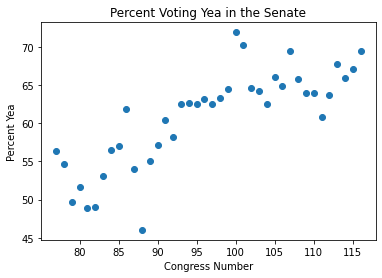

In [ ]:
grouped = inputedCongressTable.groupby('CName');
toPlot = grouped['PercentYea'].agg(np.mean);
keys = grouped.groups.keys();
plt.scatter(keys, toPlot);
plt.title('Percent Voting Yea in the Senate')
plt.xlabel('Congress Number')
plt.ylabel('Percent Yea')
plt.show()

When we group by individual congress ID over time it seems as if senators were voting on average more for yes! Could this indicate more unity across the parties? 

While this is unlikely that cannot be ruled out. One possible explanation would be that only bills that are "certain" to pass will be brought to the floor in order to avoid wasting time. Most deals are done behind closed doors away from the public. See this example for how Deocrats managed to push through [Health Care Reform](http://www.digitaljournal.com/article/285771).
While that is only one example the HuffPost made a link [here](https://www.huffpost.com/entry/backroom-deals-a-bipartis_b_442330) about these examples throughout history!


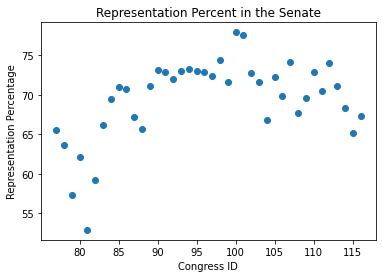

In [ ]:
grouped = inputedCongressTable.groupby('CName');
toPlot = grouped['Representation'].agg(np.mean);
keys = grouped.groups.keys();
plt.scatter(keys, toPlot);
plt.title('Representation Percent in the Senate')
plt.xlabel('Congress ID')
plt.ylabel('Representation Percentage')
plt.show()

Going back to representation of the people we see an interesting inverted U. This is the first strong example of partisanship. Why? Well the senate is equally weighted among all states (Two senators each), as a result a smaller state like Wyoming will have equal reprsenation with a behemoth like New York, this was well documented by [The Guardian](https://www.theguardian.com/us-news/2018/nov/08/democrats-republicans-senate-majority-minority-rule). 

Because of this we can see a reversion to lower representation percentage as republicans only represent smaller parts of the country but have equal and at times even larger say in the vote in the senate



## Partisanship in Congress

Let us now switch our focus to seeing the difference between Republicans and Democrats when voting over time. 

### Partisanship in the Senate

We need a way to define a vote ID to a "partisanship score" meaning, "was a specific vote particularly partisan". We will define this as the number of republicans that voted along party lines, vs the number of democrats that voted across party lines. The formulas are listed below the cell!

In [ ]:
currVID = 0;
repConsensusList = [];
demConsensusList = [];
cooperationList = [];

for i in range(len(inputedCongressTable['VoteID'])):
  #print(i)
  temp = inputedVoteTable[inputedVoteTable['VID'].isin([i,i])]
  #print(temp)
  repSum = temp['Republicans'].sum();
  demSum = temp['Democrats'].sum();

    
  if len(temp) > 1 and temp.iloc[0][1] == 'Yea' and temp.iloc[1][1] == 'Nay': # if we have a yea and a nay use them
    repY = temp.iloc[0][3]
    repN = temp.iloc[1][3]
    
    repConsensus = abs(repY - repN) / repSum

    demY = temp.iloc[0][4]
    demN = temp.iloc[1][4]
    
    demConsensus = abs(demY - demN) / demSum

    cooperation = abs((repY/repSum) - (demY/demSum))
    repConsensusList.append(repConsensus)
    demConsensusList.append(demConsensus)
    cooperationList.append(cooperation)
  else: #otherwise we have republican disagreement by not voting with the party
    repY = temp.iloc[0][3]
    repN = repSum - repY
    
    repConsensus = abs(repY - repN) / repSum

    demY = temp.iloc[0][4]
    demN = repSum - repY
    
    demConsensus = abs(demY - demN) / demSum

    cooperation = abs((repY/repSum) - (demY/demSum))
    repConsensusList.append(repConsensus)
    demConsensusList.append(demConsensus)
    cooperationList.append(cooperation)
 

demC will be the consensus among democrats on some bill computed as: 
|Democrat Yea Vote - Democrat Nay Vote| / Total Democrat votes
This is calculated exactly the same for republicans 
Cooperation the inverse of partisanship is calculated as 
| (Republican Yea/Republican Total) - (Democrat Yea / Democrat Total) |

In [ ]:
#Use a copy to preserve the original table
ict = inputedCongressTable.copy()

#turning to numpy array for insertion
rCLA = np.array(repConsensusList);
dCLA = np.array(demConsensusList);
cCLA = np.array(cooperationList);

ict.insert(11,"repC",rCLA)
ict.insert(11,"demC",dCLA)
ict.insert(11,"Partisanship",cCLA)

After having the respective demC and repC values we can being analyzing it. Let us take a look at the data given if we can plot a regression directly.

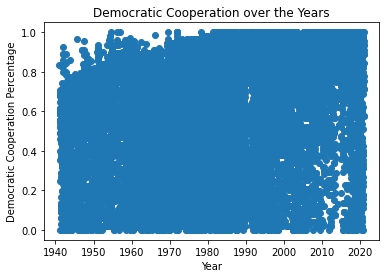

In [ ]:
plt.scatter(ict['Date'], ict['demC']);
plt.title('Democratic Cooperation over the Years')
plt.xlabel('Year')
plt.ylabel('Democratic Cooperation Percentage')
plt.show()

This graph is too hectic to decipher anything, so let us average on the years for both democrats and republicans to see if a trend exists. 

In [ ]:
#method that allows to pass in some datframe and the column to use for temp variable as averaging per year
def avgDataOverYears(home, columnName):
  toReturn = [];
  for i in range(1941,2020,1): #change after new tables come in
    #print(i)
    temp = home[home['year'].isin([i,i])]
    #print(temp)
    avgVal = temp[columnName].mean();
    # if math.isnan(demCAvg):
    #   print(i)
    toReturn.append(avgVal)
  return toReturn;

In [ ]:
tempDf = ict.copy() #make another copy to not affect the previous
tempDf['year'] = pd.DatetimeIndex(tempDf['Date']).year #isolate year as a variable to allow for use in regression as a variable


In [ ]:
demCAvgRunning = avgDataOverYears(tempDf, 'demC')
repCAvgRunning = avgDataOverYears(tempDf, 'repC')
coopAvgRunning = avgDataOverYears(tempDf, 'Partisanship')

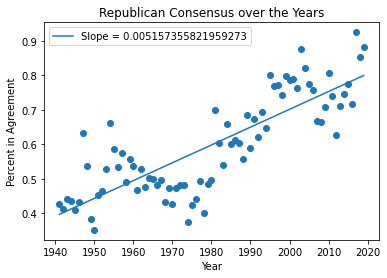

In [ ]:
rCAR = np.array(repCAvgRunning);
years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)


b,m = polyfit(years,rCAR, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, rCAR);
plt.title('Republican Consensus over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()


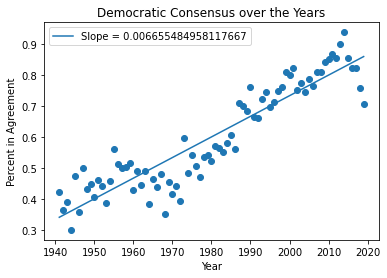

In [ ]:
dCAR = np.array(demCAvgRunning);

years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)

b,m = polyfit(years,dCAR, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, dCAR);
plt.title('Democratic Consensus over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()

**Observations**

Strong correlation for both parties to have more in-group consensus over time. We do see slight drops from the 60-80's and then a rapid increase thereafter! 

This is supported by [Time](https://time.com/2862299/how-the-united-states-is-growing-more-partisan-in-10-charts/) which presented work by the Pew Research Center. The graph titled Polrization and Presidential Approval shows smaller differences between Republicans and Democrats during the 60-80's.

Small drops are seen every four/eight years. That is of much interest and will be explored in the Machine Learning section.

It can be noted that democratic consensus has increased a lot more to catch up, and even surpass, average republican consensus. If both republican/democratic in-group cooperativity has increased partisanship must have also increased, right?


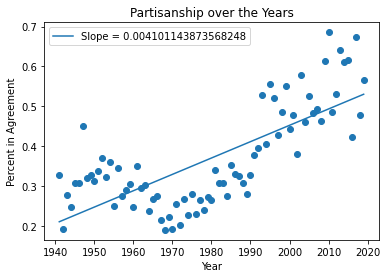

In [ ]:
cCar = np.array(coopAvgRunning);

years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)

b,m = polyfit(years,cCar, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, cCar);
plt.title('Partisanship over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()

Yes, that is exactly what we see the Partisanship graph mirrors the Democratic and Republican division.

### Partisanship in the House

Let us now do the exact same thing with the House!

In [ ]:
#Handle the unknowns
inputedHouseTable['PercentYea'] = inputedHouseTable['PercentYea'].replace("unknown", np.NaN)
inputedHouseTable['PercentYea'] = inputedHouseTable['PercentYea'].astype(float)
inputedHouseTable['Representation'] = inputedHouseTable['Representation'].replace("unknown", np.NaN)
inputedHouseTable['Representation'] = inputedHouseTable['Representation'].astype(float)
print("No representation data available")
print("Percent of house members that voted Yea on average over the entire dataset: " + str(inputedHouseTable['PercentYea'].mean()))


No representation data available
Percent of house members that voted Yea on average over the entire dataset: 70.88133315414595


We see in the house that on average over the years congressmen vote around yea about 70% of the time. This is about 8% higher than Senators. There is no current research on why this is, this remains to be investegated in the future. 

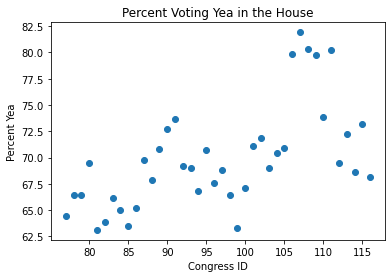

In [ ]:
grouped = inputedHouseTable.groupby('CName');
toPlot = grouped['PercentYea'].agg(np.mean);
keys = grouped.groups.keys();
plt.scatter(keys, toPlot);
plt.title('Percent Voting Yea in the House')
plt.xlabel('Congress ID')
plt.ylabel('Percent Yea')
plt.show()

The house is voting Yea much more than the senate as seen previously. It also experiences the four/eight year swings!

In [ ]:
currVID = 0;
repConsensusList = [];
demConsensusList = [];
cooperationList = [];

for i in range(len(inputedHouseTable['VoteID'])):
  temp = inputedHouseVoteTable[inputedHouseVoteTable['VID'].isin([i,i])]
  #print(temp)
  repSum = temp['Republicans'].sum();
  demSum = temp['Democrats'].sum();

    
  if len(temp) > 1 and temp.iloc[0][1] == 'Yea' and temp.iloc[1][1] == 'Nay': # if we have a yea and a nay use them
    repY = temp.iloc[0][3]
    repN = temp.iloc[1][3]
    
    repConsensus = abs(repY - repN) / repSum

    demY = temp.iloc[0][4]
    demN = temp.iloc[1][4]
    
    demConsensus = abs(demY - demN) / demSum

    cooperation = abs((repY/repSum) - (demY/demSum))
    repConsensusList.append(repConsensus)
    demConsensusList.append(demConsensus)
    cooperationList.append(cooperation)
  else: #otherwise we have republican disagreement by not voting with the party
    repY = temp.iloc[0][3]
    repN = repSum - repY
    
    repConsensus = abs(repY - repN) / repSum

    demY = temp.iloc[0][4]
    demN = repSum - repY
    
    demConsensus = abs(demY - demN) / demSum

    cooperation = abs((repY/repSum) - (demY/demSum))
    repConsensusList.append(repConsensus)
    demConsensusList.append(demConsensus)
    cooperationList.append(cooperation)

In [ ]:
ictH = inputedHouseTable.copy()
rCLA = np.array(repConsensusList);
dCLA = np.array(demConsensusList);
cCLA = np.array(cooperationList);

ictH.insert(11,"repC",rCLA)
ictH.insert(11,"demC",dCLA)
ictH.insert(11,"Partisanship",cCLA)

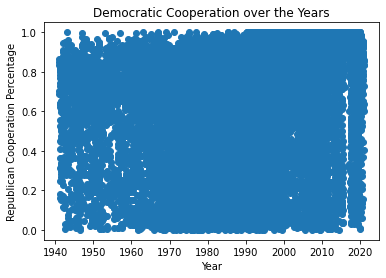

In [ ]:
plt.scatter(ictH['Date'], ictH['repC']);
plt.title('Democratic Cooperation over the Years')
plt.xlabel('Year')
plt.ylabel('Republican Cooperation Percentage')
plt.show()

Again this is way to hectic so we will average on the year.

In [ ]:
tempDf = ictH.copy() #make another copy to not affect the previous
tempDf['year'] = pd.DatetimeIndex(tempDf['Date']).year #isolate year as a variable to allow for use in regression as a variable


In [ ]:
demCAvgRunning = avgDataOverYears(tempDf, 'demC')
repCAvgRunning = avgDataOverYears(tempDf, 'repC')
coopAvgRunning = avgDataOverYears(tempDf, 'Partisanship')

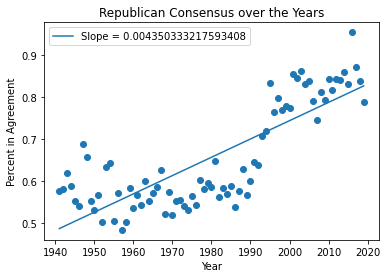

In [ ]:
rCAR = np.array(repCAvgRunning);
years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)


b,m = polyfit(years,rCAR, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, rCAR);
plt.title('Republican Consensus over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()


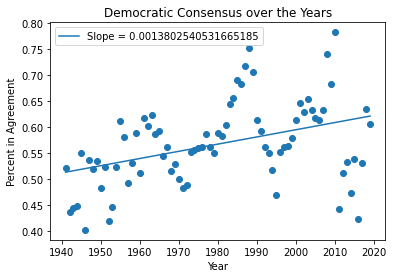

In [ ]:
dCAR = np.array(demCAvgRunning);

years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)

b,m = polyfit(years,dCAR, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, dCAR);
plt.title('Democratic Consensus over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()

**Observations**

Similarly to the Senate we see broad increase from both parties. However it is important to note that there is much less cooperation from the democrats in the House. On average they only have 60% cooperation in 2020 based on the regression line, whereas the republicans have about 82% cooperation!

The divide in the democratic party has been [documented](https://time.com/4951191/divided-democratic-party-debates-its-future/) previously, starting as early as 2017. One reason for why this was not seen in the Senate is that the Senate requires increased cooperation among Demoracts to fight the Republican majority. 


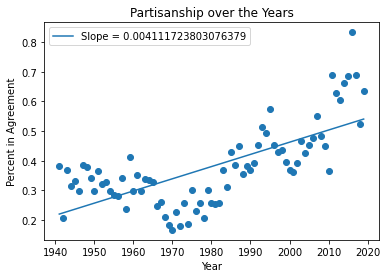

In [ ]:
cCar = np.array(coopAvgRunning);

years = [i for i in range(1941,2020,1)]
year = range(1941,2020,1)

b,m = polyfit(years,cCar, 1)
plt.plot(year, m*year +b, label=("Slope = " + str(m)));
plt.scatter(year, cCar);
plt.title('Partisanship over the Years')
plt.xlabel('Year')
plt.ylabel('Percent in Agreement')
plt.legend(loc="upper left")
plt.show()

As expected we see an increase in partisanship over the years. This research supports work done by [Pew](https://www.pewresearch.org/fact-tank/2014/06/12/polarized-politics-in-congress-began-in-the-1970s-and-has-been-getting-worse-ever-since/) that the current Congress polarization began in the 1970's. Both the Senate and House Partisanship graphs show a hard turn upward in 1970.

The other notiable kink in the graph 2001. That can be explained by unity following the 9/11 terrorist attacks.

# Part 4: Analysis, Hypothesis Testing and Machine Learning

## The Necessity of Averaging

As we saw above, there are too many points in a single year to do any predicitve measurements, the scatter is too great. However if averaged over every year general trends over time can be extracted, and that is the goal in this section.

In [ ]:
#Need to isolate year
pML = ict.copy()
pMLH = tempDf.copy()

pML['year'] = pd.DatetimeIndex(pML['Date']).year
pMLH['year'] = pd.DatetimeIndex(pMLH['Date']).year


In [ ]:
#making a dataframe for average data on year for senate
demCAvgRunning = avgDataOverYears(pML, 'demC')
repCAvgRunning = avgDataOverYears(pML, 'repC')
pY = avgDataOverYears(pML, 'PercentYea')
Rep = avgDataOverYears(pML, 'Representation')
Partisanship = avgDataOverYears(pML, 'Partisanship')
fourCode = avgDataOverYears(pML, '4Code')
eightCode = avgDataOverYears(pML, '8Code')
Month = avgDataOverYears(pML, 'Month')

In [ ]:
data = {'DemC' : demCAvgRunning,
             'RepC' : repCAvgRunning,
             'percentYea' : pY,
             'Rep' : Rep,
             "Partisanship" : Partisanship,
        'Year' : [i for i in range(1941, 2020, 1)],
        '4Code': fourCode,
        '8Code' : eightCode,
        'Month' : Month
        }
df = pd.DataFrame(data)

In [ ]:
#making a dataframe for average data on year for house
demCAvgRunning = avgDataOverYears(pMLH, 'demC')
repCAvgRunning = avgDataOverYears(pMLH, 'repC')
pY = avgDataOverYears(pMLH, 'PercentYea')
Rep = avgDataOverYears(pMLH, 'Representation')
Partisanship = avgDataOverYears(pMLH, 'Partisanship')
fourCode = avgDataOverYears(pMLH, '4Code')
eightCode = avgDataOverYears(pMLH, '8Code')
Month = avgDataOverYears(pMLH, 'Month')

In [ ]:
data = {'DemC' : demCAvgRunning,
             'RepC' : repCAvgRunning,
             'percentYea' : pY,
             'Rep' : Rep,
             "Partisanship" : Partisanship,
        'Year' : [i for i in range(1941, 2020, 1)],
        '4Code': fourCode,
        '8Code' : eightCode,
        'Month' : Month
        }
dfH = pd.DataFrame(data)

We now want to see if the partisanship that was documented through single linear regressions in our previous graphs can be supported by multiple variables!

## Senate: Multilinear Linear Regression

DemC + RepC + Percent Yea = Partisanship?

A multilinear linear regression was chosen as the first analysis because it would be expected that with democratic and republican cooperation increasing partisanship should also increase. Percent Yea was also tested to see if it was a reliable source for prediciton. It could have gone one of two ways: 
1. Senators agree more because they only vote on what is expected 
2. Partisanship always gets in the way. 

The results seem to indicate a mixture as it was an inconsequential value.

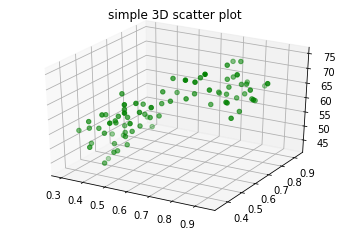

In [ ]:
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(df['DemC'], df['RepC'], df['percentYea'], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

There is possible correlation in this graph, lets dive further

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,df.iloc[0][0], df.iloc[0][1], df.iloc[0][2]], [1, df.iloc[1][0], df.iloc[1][1],  df.iloc[1][2]]])

tempArr = np.array([])
for i  in range(2,len(df),1):
  endArr = np.append(endArr,[[1, df.iloc[i][0], df.iloc[i][1],  df.iloc[i][2]]],axis=0)

regression_model = LinearRegression()
x = np.array(endArr)

regression_model.fit(x, df['Partisanship'])
print('Slope:' ,regression_model.coef_) 


Slope: [ 0.          0.609832    0.42284413 -0.00956396]


In [ ]:
#Randomly picks training and test data
X_train, X_test, y_train, y_test = train_test_split(x, df['Partisanship'], test_size=0.2)
regression_model.fit(X_train, y_train)
scores = cross_val_score(regression_model, X_train, y_train, cv=10)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.90724752 0.72889833 0.7918995  0.77703357 0.93510983 0.73810438
 0.77897966 0.89442525 0.90986349 0.67074636]
Mean: 0.8132307899368696
Standard deviation: 0.08695988937968296


We can see if over a 10 K Fold split there is strong predictive qualities

In [ ]:
regression_model.score(X_test, y_test)

0.930899636148423

A linear regression multivariate model looking at Democratic Coopertion, Republican Cooperation and Percent of Senators voting yea CAN predict Partisanship over time. However, it is important to note that based on the given slopes percent yea cannot be a reliable source. 
The model works around 93% accuracy which is extremely reliable.

## House: Multilinear Linear Regression 

DemC + RepC + Percent Yea = Partisanship?

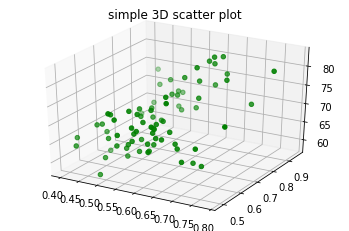

In [ ]:
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(dfH['DemC'], dfH['RepC'], dfH['percentYea'], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

There is possible correlation in this graph, lets dive further

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,dfH.iloc[0][0], dfH.iloc[0][1], dfH.iloc[0][2]], [1, dfH.iloc[1][0], dfH.iloc[1][1],  dfH.iloc[1][2]]])

tempArr = np.array([])
for i  in range(2,len(dfH),1):
  endArr = np.append(endArr,[[1, dfH.iloc[i][0], dfH.iloc[i][1],  dfH.iloc[i][2]]],axis=0)

regression_model = LinearRegression()
x = np.array(endArr)
regression_model.fit(x, dfH['Partisanship'])
print('Slope:' ,regression_model.coef_) 


Slope: [ 0.          0.08820857  1.25251728 -0.01390667]


In [ ]:
#Randomly picks training and test data
X_train, X_test, y_train, y_test = train_test_split(x, dfH['Partisanship'], test_size=0.2)
regression_model.fit(X_train, y_train)
scores = cross_val_score(regression_model, X_train, y_train, cv=10)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [ 0.86779607 -0.42675364  0.79915378  0.13010448  0.56998672  0.72356408
  0.71999351  0.7664609  -0.54923708  0.85055626]
Mean: 0.44516250645014016
Standard deviation: 0.5087687268841252


We can see if over a 10 K Fold split there is strong predictive qualities

In [ ]:
regression_model.score(X_test, y_test)

0.9252687193829312

A linear regression multivariate model looking at Democratic Coopertion, Republican Cooperation and Percent of representatives voting yea CAN predict Partisanship over time. However, it is important to note that based on the given slopes percent yea cannot be a reliable source. 
The model works around 92% accuracy which is reliable, but slightly lower than the same model for the Senate.

## Senate Ridge Regression

A Ridge regression was chosen because we believed their might be some correlation between predictor variables, and the ridge regression allows for those to be considered in the model.

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,df.iloc[0][0], df.iloc[0][1], df.iloc[0][2]], [1, df.iloc[1][0], df.iloc[1][1],  df.iloc[1][2]]])

tempArr = np.array([])
for i  in range(2,len(df),1):
  endArr = np.append(endArr,[[1, df.iloc[i][0], df.iloc[i][1],  df.iloc[i][2]]],axis=0)

regression_model = LinearRegression()
x = np.array(endArr)
X_train, X_test, y_train, y_test = train_test_split(x, df['Partisanship'], test_size=0.2)

# define model
model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)


In [ ]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [ 0.25596571  0.42952457  0.79386279  0.59962142  0.76985353  0.74338159
  0.69936952  0.58510689  0.77465369  0.58888648  0.71419333  0.71711938
  0.6992036   0.29060224  0.48202878  0.5720719   0.50030599  0.83150934
  0.68045469  0.6821312  -0.15835739  0.70092514  0.49315729  0.62541897
  0.65780173  0.82933916  0.70897875  0.74483527  0.94559133  0.67625738]
Mean: 0.6211264759294451
Standard deviation: 0.207919543661092


In [ ]:
model.score(X_test, y_test)

0.7386797112026059

The ridge regression model did not perform as well on the data as the linear model did we can reject the null hypothesis that there was correlation between predictor values.

## House Ridge Regression

A Ridge regression was chosen because we believed their might be some correlation between predictor variables, and the ridge regression allows for those to be considered in the model.

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,dfH.iloc[0][0], dfH.iloc[0][1], dfH.iloc[0][2]], [1, dfH.iloc[1][0], dfH.iloc[1][1],  dfH.iloc[1][2]]])

tempArr = np.array([])
for i  in range(2,len(dfH),1):
  endArr = np.append(endArr,[[1, dfH.iloc[i][0], dfH.iloc[i][1],  dfH.iloc[i][2]]],axis=0)

regression_model = LinearRegression()
x = np.array(endArr)
X_train, X_test, y_train, y_test = train_test_split(x, dfH['Partisanship'], test_size=0.2)

# define model
model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)


In [ ]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [ 0.48754308  0.36318277  0.51936049  0.3980991   0.39362406  0.40504296
  0.3369951   0.36991557  0.41544953  0.61373277  0.51999539  0.34696885
  0.42294998 -1.17663792  0.29288798  0.53519984  0.12205279  0.44583343
  0.43580989  0.41579261  0.33085251  0.34494673  0.45579905  0.47636819
  0.3067904   0.46389625  0.45068234  0.5567717   0.37143741  0.503426  ]
Mean: 0.36415896221743205
Standard deviation: 0.30099530239874095


In [ ]:
model.score(X_test, y_test)

0.19989359508319196

The ridge regression model did not perform well at ALL on the data at all. We can reject the null hypothesis that there was correlation between predictor values.

## Senate Nearest Neighbor

Can we use the Nearest Neighbor algorithm to predict partisanship swings during election cycles? Our intuition was that congress would be more divided during election years (4code ==0 or 8code == 0) and less divided during the middle of a term. We found that the 8code is a better predictor, so that is used below.

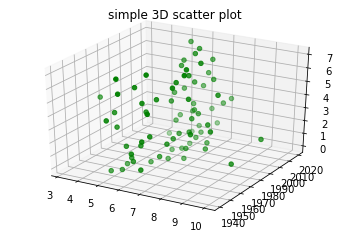

In [ ]:
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(df['Month'], df['Year'], df['8Code'], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,df.iloc[0][8], df.iloc[0][5], df.iloc[0][7]], [1, df.iloc[1][8], df.iloc[1][5],  df.iloc[1][7]]])

tempArr = np.array([])
for i  in range(2,len(df),1):
  endArr = np.append(endArr,[[1, df.iloc[i][8], df.iloc[i][5],  df.iloc[i][7]]],axis=0)
x = np.array(endArr)
#shuffle first
X_train, X_test, y_train, y_test = train_test_split(x, df['Partisanship'], test_size=0.1)

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(40):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights = 'distance', metric='manhattan')

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values


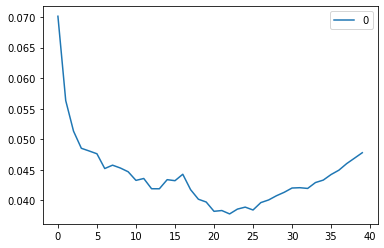

In [ ]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
 model = neighbors.KNeighborsRegressor(n_neighbors = 22, weights = 'distance',  metric='manhattan')

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                    weights='distance')

In [ ]:
model.score(X_test, y_test)

0.9135540908477525

Our intuition that there is an increase in partisanship around election years. This can be supported by the KNearestNeighboor algorithm for the clusters that occur in the 3D space around the given years in question. 

## House Nearest Neighbor 

Similarly, can we use the Nearest Neighbor algorithm to predict partisanship swings during election cycles in the House?

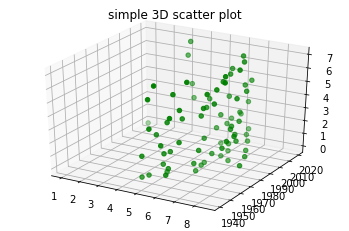

In [ ]:
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(dfH['Month'], dfH['Year'], dfH['8Code'], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [ ]:
#Make numpy array which will be our feature vector
endArr = np.array([[1,dfH.iloc[0][8], dfH.iloc[0][5], dfH.iloc[0][7]], [1, dfH.iloc[1][8], dfH.iloc[1][5],  dfH.iloc[1][7]]])

tempArr = np.array([])
for i  in range(2,len(dfH),1):
  endArr = np.append(endArr,[[1, dfH.iloc[i][8], dfH.iloc[i][5],  dfH.iloc[i][7]]],axis=0)
x = np.array(endArr)
#shuffle first
X_train, X_test, y_train, y_test = train_test_split(x, dfH['Partisanship'], test_size=0.1)

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(40):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights = 'distance', metric='manhattan')

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values


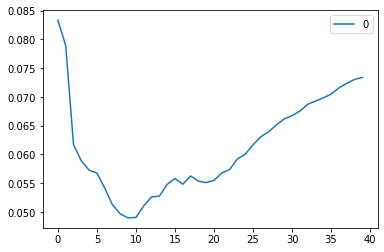

In [ ]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
 model = neighbors.KNeighborsRegressor(n_neighbors = 9, weights = 'distance',  metric='manhattan')

In [ ]:
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

In [ ]:
model.score(X_test, y_test)

0.8019148703534662

The same four/eight year uptick in partisanship exists in the House!

# Part 5: Insight, Policy Decision, and Importance

## Summary

Overall, it is clear that congressional partisanship, at least how we defined it for the purposes of this essay has increased over the last 80 years. Both parties have grown more partisan at around the same rate, and this behavior exists in both houses. Using this scraped data, we are able to build models using machine learning that can predict partisanship with considerable accuracy

## Financial Importance

Being able to predict political partisanship allows us to predict the passage of legislature, an ability that has limitless political potential. To give a recent example, in times of economic depression such as the one caused by the COVID pandemic, there have been numerous efforts to pass legislature to provide stimulus packages to American people and businessess. When this occurs, there is a considerable economic uptick. Stock brokers make billions of dollars by predicting such an uptick; accordingly, models such as these have significant importance for quants, as this [article](https://medium.com/@bradfordcross/machine-learning-vs-quants-the-advantages-of-machine-learning-in-finance-f6e8d19ebf9f) details

## Social Importance

At times, political polarization appears to be a insurmountable problem. How can the country unite in times of hardship? The first step in moving forward is recognizing historical patterns; in this case, our project details the patterns of partisanship. 

In the age of digitalization where echo chambers dictate much of what people hear and therefore the opinions they form, this problem is made more challenging.  But  machine learning algorithms and the data visualization of political partisanship may be the perfect method of penetrating digital echo chambers and act as a wake up call to the American people. If we can realize the trajectory of where we are as a society and make a renewed push to find common ground, we may be able to work together to benefit everyone. This is not a partisan report, both parties are responsible for where we are today, and both have the power to shape the future of our country.

## The future of this project

There are two main ways to take this project to the next level. First, as this paper has distinguished multiple times, there is a difference between the partisanship of the people of the US and the congressional representatives of the US. This project deals with the latter, but what of the former? Did one come before, or perhaps cause the other? To determine this, additional data sources are needed to measure citizen partisanship. However, due to digitalization revolutionizing information distribution, it will be difficult to standardize this change over time.

Second, we did not use the title or the type of motion in this project at all, despite scraping it when available. An important future step for this project would be applying natural language processing to text associated with each vote to put them in different categories. Our intuition is that certain types of votes invoke greater partisanship. A obvious recent example would be the nomination of Supreme Court Justices.